In [1]:
import numpy as np 
import pandas as pd


train = pd.read_csv('../input/train.csv')  Test data
test = pd.read_csv('../input/test.csv')  Test data

datasets = [train, test]

train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


 Preprocessing

In [2]:
import re
epic_titles = set(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'])
female_titles = set(['Lady', 'Countess', 'Dona', 'Mlle', 'Ms', 'Mme'])
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}

def mapFare(fare):
    if fare <= 7.91:
        return 0
    elif fare > 7.91 and fare <= 14.454:
        return 1
    elif fare > 14.454 and fare <= 31:
        return 2
    elif fare > 31:
        return 3

def mapAge(age):
    if age <= 16:
        return 0
    elif age > 16 and age <= 32:
        return 1
    elif age > 32 and age <= 48:
        return 2
    elif age > 48 and age <= 64:
        return 3
    elif age > 64:
        return 4
    
for dataset in datasets:
#     Adding feature of family size
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    dataset.drop([ 'SibSp', 'Parch'], axis=1, inplace=True)
    
 #    Adding title as a feature
    dataset['Title'] = dataset['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
    dataset['Title'] = dataset['Title'].apply(lambda x: x if x not in epic_titles else 'Epic')
    
  #   Fill NaN for Sex based on Title 
    dataset['Sex'] = dataset['Sex'].fillna(dataset['Title'].apply(lambda x: 'female' if x in female_titles else 'male'))

    # Changing from old names to new names
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

    # Mapping title columns to int values
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Epic": 5}
    dataset['Title'] = dataset['Title'].apply(lambda x: title_mapping[x] if x in title_mapping else 5)

    # Mapping Sex columns
    dataset['Sex'] = dataset['Sex'].map( {"female": 0, "male": 1} ).astype(int)

    # Mapping Age from 0 to 4
    dataset['Age'] = dataset['Age'].fillna(dataset['Age'].mean())  First replacing NaN with meanvalue
    dataset['Age'] = dataset['Age'].apply(lambda x: mapAge(x))
    dataset['Age'] = dataset['Age'].astype(int)

    # Mapping Fare
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
    dataset['Fare'] = dataset['Fare'].apply(lambda x: mapFare(x))
    dataset['Fare'] = dataset['Fare'].astype(int)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping deck feature
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
    # we can now drop the cabin feature
    dataset.drop(['Cabin'], axis=1, inplace=True)

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,IsAlone,Title,Deck
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0,0,2,0,1,8
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3,1,2,0,3,3
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,1,0,1,1,2,8
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2,1,0,113803,3,0,2,0,3,3
4,5,0,3,"Allen, Mr. William Henry",1,2,0,0,373450,1,0,1,1,1,8


In [4]:
# Lookin at sex as a feature
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).agg(['mean', 'count', 'sum'])

Survived           
         mean count  sum
Sex                     
0    0.742038   314  233
1    0.188908   577  109

In [5]:
# Selecting columsn for splitting of data in next section
y = train[['Survived']]
x = train.drop(columns=['Name', 'Ticket', 'Survived', 'PassengerId'])
x.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
       'FamilySize', 'IsAlone', 'Title', 'Deck'],
      dtype='object')

 Correlation map

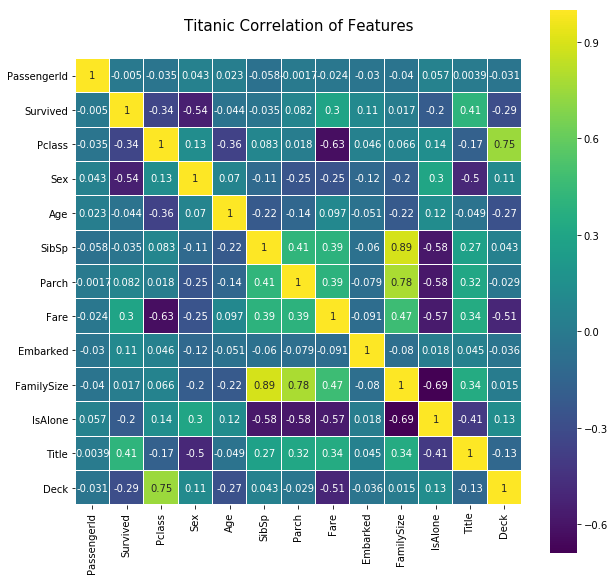

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
plt.title('Titanic Correlation of Features', y=1.05, size=15)
sns.heatmap(train.select_dtypes([np.number]).astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

 Random Forest Classifier with Grid Search

In [10]:
# Parameters for grid search
parameters = {
 'n_estimators'      : [50, 100] + [x for x in range(200, 250, 30)],
 'max_depth'         : [x for x in range(5,10)] + [100],
 'random_state'      : [0, 1],
 'max_features'      : ['auto', 'log2'],
}
rf_vanilla = RandomForestClassifier(n_estimators=100, max_depth=100)
rf_vanilla = rf_vanilla.fit(train_x, train_y)

# Looking at importance of features
fti = rf_vanilla.feature_importances_
print("Feature imporantances out of the box:")
for i, feat in enumerate(list(train_x.columns)):
     print('\t{0:20s} : {1:>.6f}'.format(feat, fti[i]))


GS_rf = GridSearchCV(RandomForestClassifier(), parameters, cv=10, n_jobs=-1)
GS_rf.fit(x, np.ravel(y))
preds = GS_rf.predict(test_x)
print('Accuracy with grid searched rf: ', accuracy_score(preds, test_y))
print('Best params', GS_rf.best_params_)

#Did return "Best params {'max_depth': 6, 'max_features': 'auto', 'n_estimators': 240, 'random_state': 0}"

In [1]:
 # Testing all classifiers
rf = RandomForestClassifier(n_estimators=50, max_depth=100, n_jobs=-1)
rf.fit(x, np.ravel(y))
preds = rf.predict(test_x)
print('Accuracy with rf: ', accuracy_score(preds, test_y))

dt = DecisionTreeClassifier()
dt.fit(train_x, train_y)
preds = dt.predict(test_x)
print('Accuracy with dt: ', accuracy_score(preds, test_y))

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(train_x, train_y)

preds = neigh.predict(test_x)
print('Accuracy with kneigh: ', accuracy_score(preds, test_y))

 Testing many different classifiers for benchmarking

In [12]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
      "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
      "Naive Bayes", "QDA"]

classifiers = [
 KNeighborsClassifier(3),
 SVC(kernel="linear", C=0.025),
 SVC(gamma=2, C=1),
 GaussianProcessClassifier(1.0 * RBF(1.0)),
 DecisionTreeClassifier(max_depth=5),
 RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
 MLPClassifier(alpha=1, max_iter=500),
 AdaBoostClassifier(),
 GaussianNB(),
 QuadraticDiscriminantAnalysis()]

for i, classifier in enumerate(classifiers):
 classifier.fit(train_x, train_y)
 preds = classifier.predict(test_x)
 print(f"Predicting with {names[i]}, accuracy: {accuracy_score(preds, test_y)}")

 Keras Binary classifier

In [13]:
# Importing libraries for building the neural network
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

print(tf.test.gpu_device_name())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [14]:
def create_baseline(optimizer='adam', init='uniform'):
    # create model
    if verbose: print("Create model with optimizer: %s; init: %s" % (optimizer, init) )
        model = Sequential()
        model.add(Dense(16, input_dim=train_x.shape[1], kernel_initializer=init, activation='relu'))
        model.add(Dense(8, kernel_initializer=init, activation='relu'))
        model.add(Dense(4, kernel_initializer=init, activation='tanh'))
        model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
        #Compile model
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [15]:
#  Training model
verbose = 1
gridsearch = False
with tf.device('/GPU:0'):
    if gridsearch:
        parameters = {
         'optimizer' : ['rmsprop', 'adam'],
         'init' : ['normal', 'uniform'],
         'epochs' : [100, 200],
         'batch_size' : [5, 10, 15],
             }
            
        model = KerasClassifier(build_fn=create_baseline, verbose=0)

        grid_model = GridSearchCV(estimator=model, param_grid=parameters)
        grid_result = grid_model.fit(train_x, train_y)

        summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']
        if verbose: 
            for mean, stdev, param in zip(means, stds, params):
                 print("%f (%f) with: %r" % (mean, stdev, param))
        elapsed_time = time.time() - start_time  
        print ("Time elapsed: ",timedelta(seconds=elapsed_time))

        best_epochs = grid_result.best_params_['epochs']
        best_batch_size = grid_result.best_params_['batch_size']
        best_init = grid_result.best_params_['init']
        best_optimizer = grid_result.best_params_['optimizer']
    else:
        best_epochs = 200
        best_batch_size = 5
        best_init = 'uniform'
        best_optimizer = 'adam'

In [16]:
#  Create a classifier with best parameters for whole dataset
with tf.device('/GPU:0'):
    model = KerasClassifier(build_fn=create_baseline, optimizer=best_optimizer, init=best_init, epochs=best_epochs, batch_size=best_batch_size, verbose=0)
    model.fit(x, y)

In [17]:
# Predicting values
with tf.device('/GPU:0'):
    preds = model.predict(test_x)
    print(f"Keras Classifiers accuracy: {accuracy_score(preds, test_y)}")
    

In [18]:
final_model = SVC(gamma=2, C=1)
final_model.fit(x, np.ravel(y))

In [19]:
#  Selecting columsn for splitting of data in next section
test_data = test.drop(columns=['Name', 'Ticket', 'PassengerId'])

# Predicting values from testing set
with tf.device('/GPU:0'):
    preds = final_model.predict(test_data)

pred_df = test[['PassengerId']].copy()
pred_df['Survived'] = preds
pred_df.to_csv('submission_svc.csv', index=False)
pred_df.sample(10)